In [1]:
import numpy as np
import torch

In [2]:
from pathlib import Path

In [3]:
import os

In [4]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import NearestNeighbors

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# https://plotly.com/python/creating-and-updating-figures/
import plotly.graph_objects as go

from mpl_toolkits import mplot3d

In [6]:
import sys
sys.path.append('../') # now can access entire repository, (important when running locally)

# from orbit_datasets import neworbits, versatileorbits, staticorbits
from ldcl.data import neworbits, versatileorbits, staticorbits

In [7]:
orbits_dataset = neworbits.OrbitsDataset()
orbits_loader = torch.utils.data.DataLoader(
    dataset = orbits_dataset,
    shuffle = True,
    batch_size = 1,
)

It took 1.9471969604492188 time to finish the job.


In [8]:
def getRepresentations(encoder_location):
    branch_encoder = torch.load(encoder_location, map_location=torch.device('cpu'))
    branch_encoder.eval()
    
    encoder_outputs_list = []
    target_values = []

    for it, (input1, input2, y) in enumerate(orbits_loader):
        predicted_representation = branch_encoder(input1.float()).detach().numpy()[0]
        encoder_outputs_list.append(predicted_representation)

        #append conserved quantities to the end of the representation for plotting, y = (1, )
        #[2=phi0,3=energy,4=angular_momentum] discard [0=eccentricity, 1=semimajor_axis]
        target_values.append(np.array([y[0][2],y[0][3],y[0][4]]))
        
    encoder_outputs = np.vstack(encoder_outputs_list)
    target_values = np.vstack(target_values)

    phi0_c_values = target_values[:,0]
    energy_c_values = target_values[:,1]
    angular_momentum_c_values = target_values[:,2]
    
    return encoder_outputs, [phi0_c_values, energy_c_values, angular_momentum_c_values]

# Important:
## Run cells from the start of each heading to plot properly

### infoNCE Loss, Projection Head with 1 hidden layer, 3 dimensional embedding

In [62]:
ENCODER_PATH = Path("saved_models/simclr_infoNCE_1hidden_head/final_encoder.pt")
print(ENCODER_PATH)
encoder_outputs, conserved_quantities = getRepresentations(ENCODER_PATH)

saved_models\simclr_infoNCE_1hidden_head\final_encoder.pt


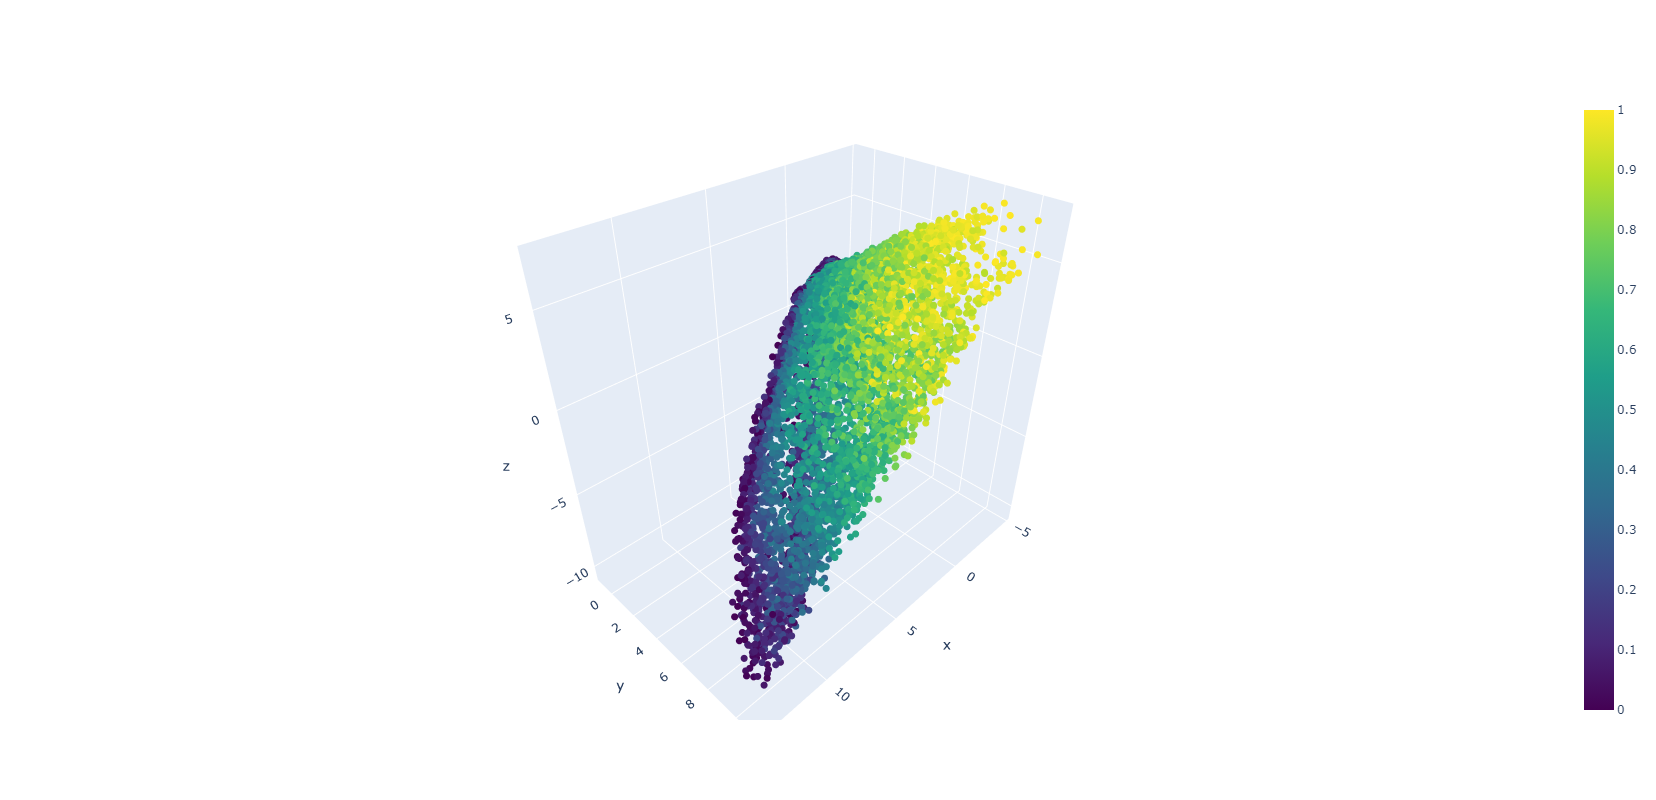

In [63]:
fig = go.Figure(
        data=[go.Scatter3d(
        x=encoder_outputs[:, 0],
        y=encoder_outputs[:, 1],
        z=encoder_outputs[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=conserved_quantities[2], # 0 for angle, 1 for energy, 2 for angular momentum
            colorscale='viridis',
            opacity=1,
            showscale = True
        )
    )],
    layout=go.Layout(height=800, width=1000)
)
fig.show()

### Notes
Weird shape, does encode phi<sub>0</sub> and angular momentum, but energy is still wonky\
shape is hollow, very bizarre

### infoNCE Loss, Projection Head with 2 hidden layers, 3 dimensional embedding

In [102]:
ENCODER_PATH = Path("saved_models/simclr_infoNCE_2hidden_head/final_encoder.pt")
print(ENCODER_PATH)
encoder_outputs, conserved_quantities = getRepresentations(ENCODER_PATH)

saved_models\simclr_infoNCE_2hidden_head\final_encoder.pt


In [103]:
fig = go.Figure(
        data=[go.Scatter3d(
        x=encoder_outputs[:, 0],
        y=encoder_outputs[:, 1],
        z=encoder_outputs[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=conserved_quantities[1], # 0 for angle, 1 for energy, 2 for angular momentum
            colorscale='viridis',
            opacity=1,
            showscale = True
        )
    )],
    layout=go.Layout(height=800, width=1000)
)
fig.show()

### Notes
Successfully embeds angle (radially around the shape) and angular momentum (distance from center)\
Embedding for energy looks very weird, somewhat looks like lower energies are in the "center" of the shape, but hard to tell, further experiments required\
appears to look like some kind of two dimensional surface

### InfoNCE, Projection head with two hidden layers, 4 dimensional embedding

In [20]:
from sklearn.decomposition import PCA

In [74]:
ENCODER_PATH = Path("saved_models/simclr_infoNCE_2hidden_head_4dim/final_encoder.pt")
print(ENCODER_PATH)
encoder_outputs, conserved_quantities = getRepresentations(ENCODER_PATH)

saved_models\simclr_infoNCE_2hidden_head_4dim\final_encoder.pt


In [75]:
print(encoder_outputs.shape)

(10240, 4)


In [76]:
pca = PCA(n_components = 3)
pca.fit(encoder_outputs)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.69542104 0.25082472 0.03335181]
0.9795975685119629


In [77]:
pca_outputs = pca.fit_transform(encoder_outputs)
print(pca_outputs.shape)

(10240, 3)


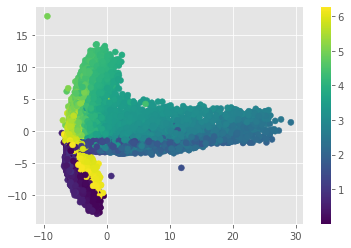

In [78]:
plt.scatter(pca_outputs[:,0], pca_outputs[:,1], c = conserved_quantities[0], cmap = 'viridis')
plt.colorbar()
plt.show()

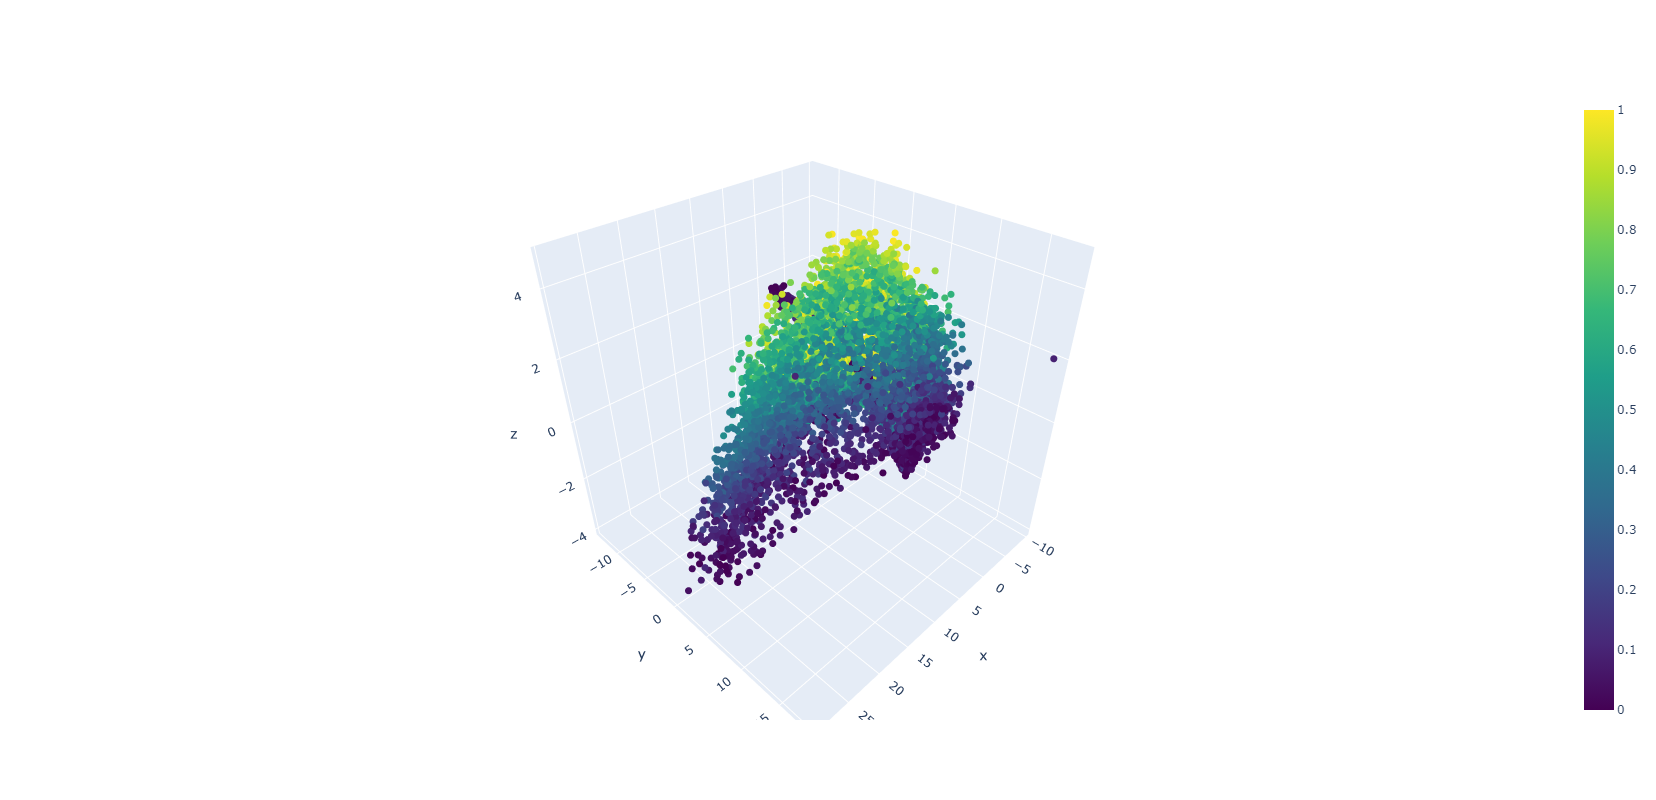

In [79]:
fig = go.Figure(
        data=[go.Scatter3d(
        x=pca_outputs[:, 0],
        y=pca_outputs[:, 1],
        z=pca_outputs[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=conserved_quantities[2], # 0 for angle, 1 for energy, 2 for angular momentum
            colorscale='viridis',
            opacity=1,
            showscale = True
        )
    )],
    layout=go.Layout(height=800, width=1000)
)
fig.show()

### Notes
Bizarre looking shape, viewed from along the z axis looks like a T?\
First two principal components explain almost 95% of the total variance, third and fourth seem kinda useless?\
The distribution of angle looks really weird over this new shape, but angular momentum still seems to be encoded pretty well except for one weird "fin" at the bottom\
Also note the distribution along the first two principal components, embedding space seems to be less well-shaped\
Seems like deeper projector is confounding results, will test again with original projector

### InfoNCE, projection head with one hidden layer, 4 dimensional embedding

In [97]:
ENCODER_PATH = Path("saved_models/simclr_infoNCE_1hidden_head_4dim/final_encoder.pt")
print(ENCODER_PATH)
encoder_outputs, conserved_quantities = getRepresentations(ENCODER_PATH)

saved_models\simclr_infoNCE_1hidden_head_4dim\final_encoder.pt


In [98]:
pca = PCA(n_components = 3)
pca.fit(encoder_outputs)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.8702993  0.08902137 0.03714847]
0.9964691177010536


In [99]:
pca_outputs = pca.fit_transform(encoder_outputs)
print(pca_outputs.shape)

(10240, 3)


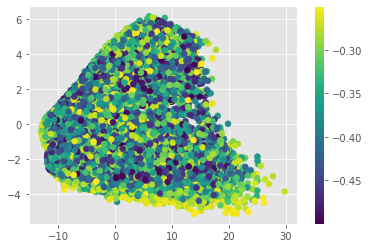

In [100]:
plt.scatter(pca_outputs[:,0], pca_outputs[:,1], c = conserved_quantities[1], cmap = 'viridis')
plt.colorbar()
plt.show()

In [101]:
fig = go.Figure(
        data=[go.Scatter3d(
        x=pca_outputs[:, 0],
        y=pca_outputs[:, 1],
        z=pca_outputs[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=conserved_quantities[0], # 0 for angle, 1 for energy, 2 for angular momentum
            colorscale='viridis',
            opacity=1,
            showscale = True
        )
    )],
    layout=go.Layout(height=800, width=1000)
)
fig.show()

## Notes
For some bizarre reason, there seems to be two PCA??? results are not deterministic wtf\
I'm probably messing smthg up, so I'll check that out\
The shape is quite bizarre, looking at the colors for phi<sub>0</sub> specifically, it seems to intersect itself